<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
from fastai.vision.all import *
from torchsummary import summary

In [2]:
torch.cuda.set_device(2)
default_device()

device(type='cuda', index=2)

In [3]:
path = Path("/raid/cs152/datasets/PalmOrPineResized//")
path.ls()

(#5) [Path('/raid/cs152/datasets/PalmOrPineResized/resnet18-1.pkl'),Path('/raid/cs152/datasets/PalmOrPineResized/models'),Path('/raid/cs152/datasets/PalmOrPineResized/Pine'),Path('/raid/cs152/datasets/PalmOrPineResized/.DS_Store'),Path('/raid/cs152/datasets/PalmOrPineResized/Palm')]

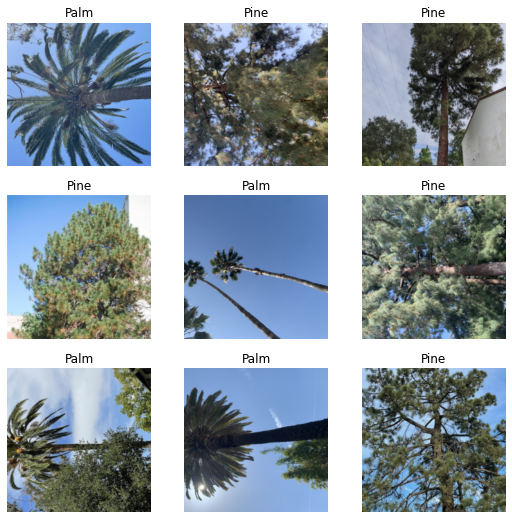

In [4]:
dls = ImageDataLoaders.from_folder(path, valid_pct=0.2, item_tfms=Resize(224), num_workers=16)
dls.show_batch()
# file <filename> on invalid files

In [5]:
print("Validation dataset size:", len(dls.valid_ds))
print("Training dataset size:", len(dls.train_ds))

Validation dataset size: 57
Training dataset size: 232


In [6]:
learn = cnn_learner(dls, resnet18, metrics=accuracy)

In [7]:
summary(learn.model);

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       (9,408)
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
|    └─Sequential: 2-5                   --
|    |    └─BasicBlock: 3-1              (73,984)
|    |    └─BasicBlock: 3-2              (73,984)
|    └─Sequential: 2-6                   --
|    |    └─BasicBlock: 3-3              (230,144)
|    |    └─BasicBlock: 3-4              (295,424)
|    └─Sequential: 2-7                   --
|    |    └─BasicBlock: 3-5              (919,040)
|    |    └─BasicBlock: 3-6              (1,180,672)
|    └─Sequential: 2-8                   --
|    |    └─BasicBlock: 3-7              (3,673,088)
|    |    └─BasicBlock: 3-8              (4,720,640)
├─Sequential: 1-2                        --
|    └─AdaptiveConcatPool2d: 2-9         --
|    |    └─AdaptiveAvgPool2d: 3-9       --
|    

In [26]:
learn.lr_find()

In [8]:
learn.fine_tune(4)

epoch,train_loss,valid_loss,accuracy,time
0,0.990410,3.057870,0.456140,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.311992,1.460777,0.578947,00:03
1,0.231571,0.424862,0.807018,00:03
2,0.189973,0.218993,0.929825,00:03
3,0.148667,0.184495,0.929825,00:03


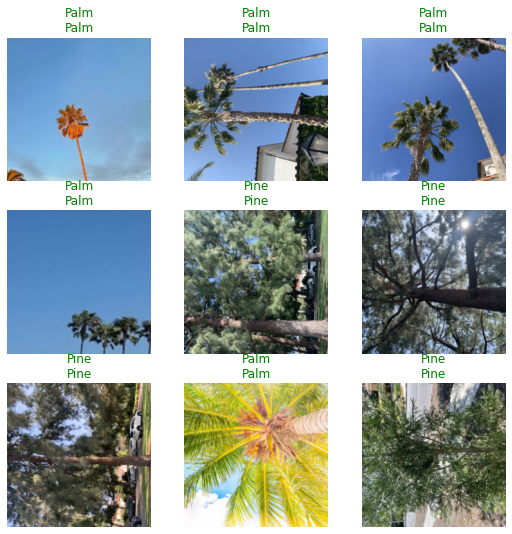

In [9]:
learn.show_results()

In [10]:
interp = ClassificationInterpretation.from_learner(learn)

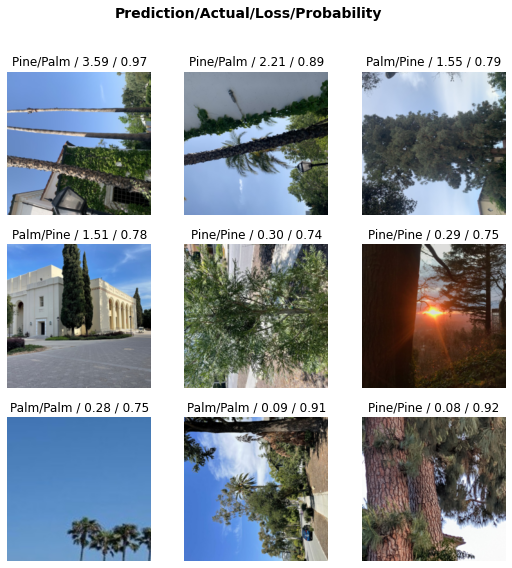

In [11]:
# interp.plot_top_losses(9)

def plot_top_losses_fix(interp, k, largest=True, **kwargs):
        losses,idx = interp.top_losses(k, largest)
        if not isinstance(interp.inputs, tuple): interp.inputs = (interp.inputs,)
        if isinstance(interp.inputs[0], Tensor): inps = tuple(o[idx] for o in interp.inputs)
        else: inps = interp.dl.create_batch(interp.dl.before_batch([tuple(o[i] for o in interp.inputs) for i in idx]))
        b = inps + tuple(o[idx] for o in (interp.targs if is_listy(interp.targs) else (interp.targs,)))
        x,y,its = interp.dl._pre_show_batch(b, max_n=k)
        b_out = inps + tuple(o[idx] for o in (interp.decoded if is_listy(interp.decoded) else (interp.decoded,)))
        x1,y1,outs = interp.dl._pre_show_batch(b_out, max_n=k)
        if its is not None:
            plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), interp.preds[idx], losses,  **kwargs)
        
plot_top_losses_fix(interp, 9)

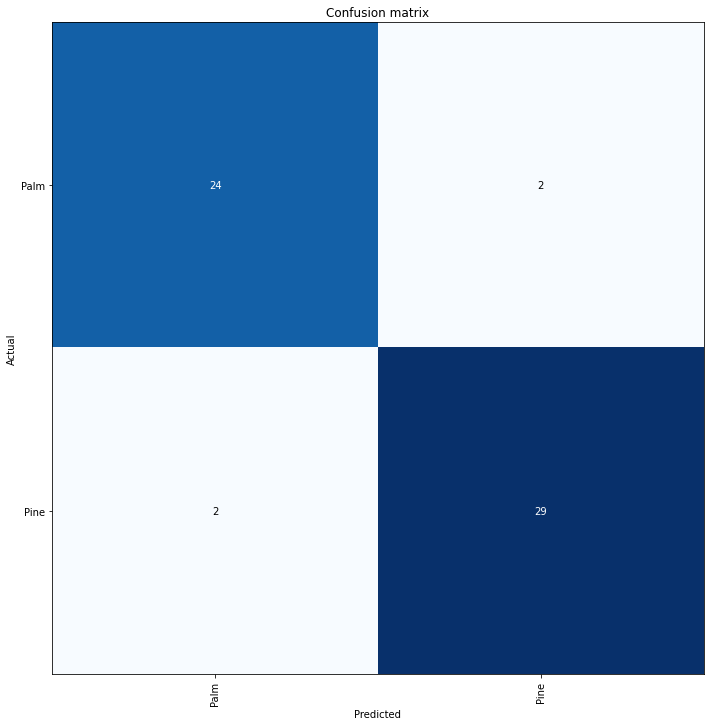

In [12]:
interp.plot_confusion_matrix(figsize=(10, 10))

In [17]:
learn.export("./resnet18-1.pkl")

In [19]:
!mv /raid/cs152/datasets/PalmOrPineResized/resnet18-1.pkl .